# Credit Risk Prediction with Logistic Regression

This notebook uses a logistic regression model on the preprocessed LendingClub loan dataset to predict whether a borrower will default.  
The performance will be evaluated using precision, recall, F1-score, and ROC AUC.

We also use a balanced class weight strategy to handle class imbalance.

In [ ]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import time

## Load and Sample Dataset

We'll use a sample of 500,000 rows to balance performance and speed.


In [2]:
# Load the preprocessed data set from notebook 02_cleaning_and_preprocessing.ipynb
df_encoded = pd.read_csv('../data/cleaned_credit_data.csv')

# Check number of rows in the cleaned dataset
print(f"Number of rows: {df_encoded.shape[0]}")

# Sample 500,000 rows from the dataset
df_sample = df_encoded.sample(n=500000, random_state=42)

# Split into features and target
X = df_sample.drop('default', axis=1)
y = df_sample['default']

Number of rows: 1345310


### Class Distribution

Before training any models, it's important to understand the target variable's distribution. In this case, the dataset is imbalanced — there are many more repaid loans than defaulted ones. This imbalance affects model performance and must be handled during training.


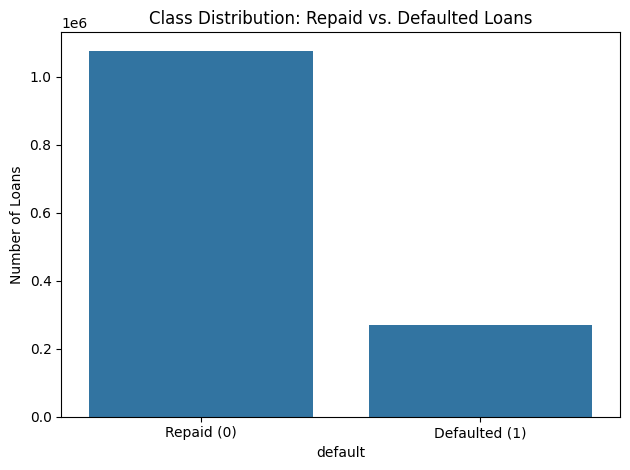

In [ ]:
sns.countplot(x='default', data=df_encoded)
plt.title('Class Distribution: Repaid vs. Defaulted Loans')
plt.xticks([0, 1], ['Repaid (0)', 'Defaulted (1)'])
plt.ylabel('Number of Loans')
plt.tight_layout()
plt.show()

## Split into Train and Test Sets

We'll use 80% of the data for training and 20% for testing, preserving class balance using stratification.


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,            
    random_state=42,          
    stratify=y                # Keeps same default/paid ratio in both sets
)

## Feature Scaling
Feature scaling is a crucial preprocessing step in many machine learning workflows, especially when using models like logistic regression. In our dataset, the features (also known as independent variables) include numeric values such as `loan_amnt`, `annual_inc`, and `int_rate`, as well as binary indicators resulting from one-hot encoding categorical variables like `home_ownership` or `purpose`. These features exist on very different numerical scales — for example, `loan_amnt` might range from 1,000 to 40,000, while interest rates might be between 5% and 30%, and one-hot encoded columns are either 0 or 1. Logistic regression is sensitive to such scale differences because it relies on gradient-based optimization to find the best coefficients for each feature. If some features have much larger values than others, they can disproportionately influence the model, causing it to converge slowly or produce suboptimal results. To address this, we use **standard scaling**, which transforms each feature so that it has a mean of 0 and a standard deviation of 1. 

This is done using the formula:  
$$ z = \frac{x - \mu}{\sigma} $$

where $x$ is the original value, $\mu$ is the mean of the feature, and $\sigma$ is its standard deviation. Standardizing ensures that all features contribute equally during training and improves both the speed and stability of model convergence. This step is especially important when dealing with high-dimensional data, as we are here with hundreds of input features.


In [4]:
scaler = StandardScaler()

# Fit only on training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data using the same scaler
X_test_scaled = scaler.transform(X_test)

## Train Logistic Regression

We use:
- `max_iter=2000` to ensure convergence
- `class_weight='balanced'` to address class imbalance

In [5]:
start_time = time.time()

model = LogisticRegression(
    max_iter=2000,           
    class_weight='balanced'  
)
model.fit(X_train_scaled, y_train)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Training time: 6.98 seconds


## Evaluate Model Performance

We check accuracy, precision, recall, F1-score, and ROC AUC.


In [6]:
# Predict labels and probabilities
y_pred = model.predict(X_test_scaled)              # Predicted class labels (0 or 1)
y_proba = model.predict_proba(X_test_scaled)[:, 1] # Probability of default (for AUC)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
[[51283 28791]
 [ 6497 13429]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.64      0.74     80074
           1       0.32      0.67      0.43     19926

    accuracy                           0.65    100000
   macro avg       0.60      0.66      0.59    100000
weighted avg       0.77      0.65      0.68    100000

ROC AUC Score: 0.7140852436328274


## Interpretation

- **Precision (Class 1)**: Out of all predicted defaults, how many were actually defaults.
- **Recall (Class 1)**: Out of all true defaults, how many the model caught.
- **F1-score (Class 1)**: Balance of precision and recall.
- **ROC AUC**: Overall ability of the model to separate defaulters from non-defaulters.

These metrics are especially important in **credit risk** where:
- False positives = denying a good borrower
- False negatives = approving a risky borrower

We aim to **maximize recall** while keeping decent precision.


### Logistic Regression Results (Sample Size: 500,000, Training Set Size: 400,000, Test Set Size: 100,000)

The logistic regression model was trained on a random sample of 500,000 rows from the cleaned LendingClub dataset. Prior to training, all features were standardized using z-score scaling, and class imbalance was addressed by applying class weighting to penalize misclassification of the minority class (defaults). The model was trained with 2,000 maximum iterations to ensure convergence given the high dimensionality of the feature space.

The model achieved an overall **accuracy of 65%**, reflecting its ability to correctly classify the majority of loans. However, due to the dataset's imbalance and the complexity of default behavior, class-specific performance is more informative. For the default class, the model attained a **recall of 0.67**, meaning it was able to identify 67% of all true defaulters. Precision for this class was **0.32**, indicating a high rate of false positives — a common issue when prioritizing recall in credit risk scenarios.

The **ROC AUC score was 0.714**, suggesting moderate discriminatory power between defaulters and non-defaulters. This makes logistic regression a transparent and interpretable starting point for credit risk modeling, though its linear nature limits its ability to capture more nuanced patterns in borrower behavior.

These results establish a reliable performance baseline for evaluating more advanced models in subsequent notebooks, such as decision trees, random forests, and gradient boosting machines.

## Next Steps

In the following notebooks, we'll compare this logistic regression model to:
- Random Forest
- XGBoost
- LightGBM

We'll evaluate each model using:
- Accuracy
- Precision, Recall, F1
- ROC AUC
- Training time

# Credit Risk Prediciton with Logistic Regression Results

## Confusion Matrix

The confusion matrix provides a detailed breakdown of predicted vs. actual classifications. It helps us understand how well the model distinguishes between repaid and defaulted loans, including false positives (predicting default when the loan is actually repaid) and false negatives (failing to catch a true default).


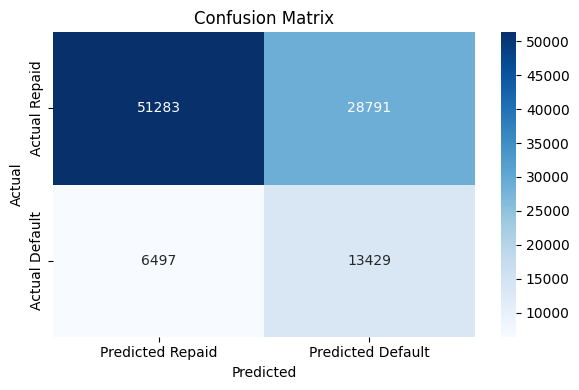

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Repaid', 'Predicted Default'],
            yticklabels=['Actual Repaid', 'Actual Default'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### Confusion Matrix Analysis

The confusion matrix provides a granular breakdown of how well the model classified repaid and defaulted loans. Each cell in the matrix corresponds to a combination of actual and predicted labels:

- **True Negatives (Top-Left: 51,283)**: These are loans that were actually repaid and correctly predicted as repaid.
- **False Positives (Top-Right: 28,791)**: These are loans that were actually repaid but incorrectly predicted as defaults.
- **False Negatives (Bottom-Left: 6,497)**: These are actual defaults that the model failed to identify, classifying them as repaid.
- **True Positives (Bottom-Right: 13,429)**: These are loans that defaulted and were correctly predicted as such.

From this matrix, we can see that while the model does a good job capturing many defaults (**13,429 true positives**), it still misses a significant number (**6,497 false negatives**). Similarly, the high number of false positives (**28,791**) indicates that the model is also frequently misclassifying non-defaulters as defaulters, which may lead to **lost business opportunities** if deployed in production.

This trade-off reflects the limitations of logistic regression in complex, imbalanced financial data. In particular, the **false positive rate is relatively high**, which can hurt precision. However, its **high recall for defaulters** is a desirable property in credit risk modeling, where it's often more costly to miss a defaulter than to mistakenly flag a repayer. This visual summary reinforces why more advanced models may be required to optimize both sides of the classification trade-off.

## ROC Curve and AUC Score

The ROC (Receiver Operating Characteristic) curve visualizes the trade-off between the true positive rate (recall) and the false positive rate across different classification thresholds. The Area Under the Curve (AUC) quantifies this performance — a higher AUC means the model is better at distinguishing between classes.


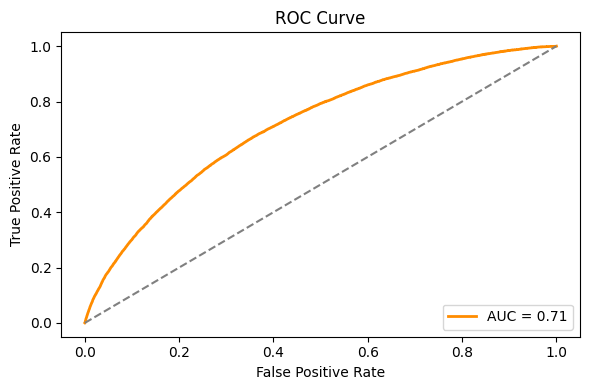

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### ROC Curve Analysis

The ROC (Receiver Operating Characteristic) curve visually illustrates the trade-off between the **True Positive Rate** (Recall) and the **False Positive Rate** across different classification thresholds. In this case, the curve rises well above the diagonal baseline, which indicates that the model performs significantly better than random guessing.

The **AUC (Area Under the Curve)** score of approximately **0.71** suggests that the model has a **moderate ability to distinguish** between defaulters and non-defaulters. While this is not outstanding, it does show that the logistic regression model captures meaningful patterns in the data. However, there's still substantial room for improvement, particularly in reducing false positives without sacrificing too many true positives.

This analysis sets a useful baseline for comparing more complex models like decision trees, random forests, or gradient boosting machines, which may achieve higher ROC AUC scores and more optimal classification thresholds.


## Precision-Recall Curve

This curve is especially useful for imbalanced datasets. It shows the trade-off between precision (how many predicted defaults were correct) and recall (how many actual defaults were caught). A good model tries to keep both high.


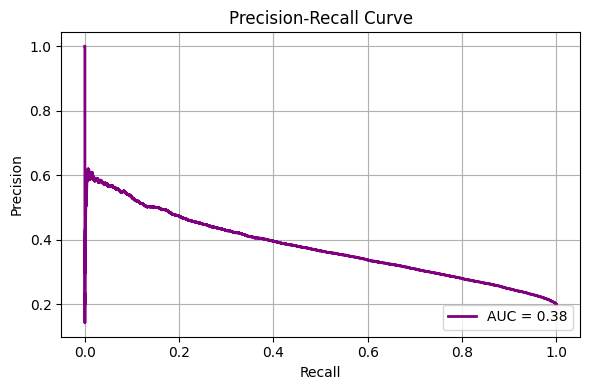

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, lw=2, color='purple', label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Precision-Recall Curve Analysis

The Precision-Recall (PR) curve provides a detailed view of how well the model distinguishes between the **default** and **non-default** classes, especially important for **imbalanced datasets** like this one. In this case, the PR AUC (Area Under the Curve) is **0.377**, which indicates that while the model captures some meaningful pattern, its precision–recall trade-off is relatively weak overall.

At low recall levels (i.e. when identifying only a small number of defaulters), the model starts with relatively high precision, meaning it's accurate when it's confident. However, as the model tries to identify more defaulters (increasing recall), precision drops significantly, suggesting more **false positives** (incorrectly predicting defaults) are being introduced.

A PR AUC of 0.38 means that, on average, the model is not very reliable in balancing precision and recall — much closer to random guessing (which would be the proportion of positives in the dataset). This outcome is typical for simple models like logistic regression on high-dimensional, noisy financial data, and it reinforces the need to try more sophisticated models that can better capture complex relationships in the data.

We'll use this result as a baseline for evaluating whether other classifiers — such as decision trees, random forests, or gradient boosting — can improve this performance.
